<h1 style="text-decoration :underline;color:red">Prédiction du vainqueur :</h1>

<p style="color:blue">Le but de ce notebook est de déterminer le vainqueur entre le favori et le challenger ainsi que la probabilité de victoire de chacun des joueurs. Ensuite on cherchera à déterminer l'écart significatif entre nos probabilités de victoires et celles des bookmakers pour parier sur les bons matchs afin d'obtenir le meilleur gain, ROI.</p>

<h2 style="text-decoration :underline;color:green">Module utilisé lors de ce notebook :</h2>

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

pd.set_option('max_columns', 40)

<h2 style="text-decoration :underline;color:green">lecture du fichier et nettoyage:</h2>

In [21]:
#df = pd.read_csv("atp_data.csv")
df = pd.read_csv("data_clean_all.csv",index_col=0)

In [22]:
#on enlève les variables non pertinentes pour l'algo
df= df.drop(["Favori","Challenger","Comment","Date","Location","Series","ATP","Best of","Winner","Wsets","Lsets"],axis=1)
df = df.reset_index().drop("index",axis=1)

In [23]:
df

,Rank_F,PS_F,B365_F,elo_F,proba_elo_F,TV_F,TV_surf_F,sets_F,Rank_C,PS_C,B365_C,elo_C,proba_elo_C,TV_C,TV_surf_C,sets_C,Tournament,Court,Surface,Round,Vainqueur,moy_elo_F,moy_elo_C
0,58,1.719,1.615,1618.182210,0.681306,0.500000,0.500000,0.0,246,2.21,2.200,1486.195239,0.318694,0.428571,0.500000,0.0,Qatar Exxon Mobil Open,Outdoor,Hard,1st Round,challenger,-36.522332,-20.871951
1,6,1.385,1.364,1820.759485,0.765687,0.763158,0.720000,0.0,43,3.25,2.875,1615.057648,0.234313,0.461538,0.428571,0.0,Qatar Exxon Mobil Open,Outdoor,Hard,1st Round,challenger,19.791315,41.588209
2,39,1.746,1.571,1654.468551,0.594046,0.666667,0.600000,0.0,67,2.18,2.250,1588.330984,0.405954,0.571429,0.555556,0.0,Qatar Exxon Mobil Open,Outdoor,Hard,1st Round,favori,15.865896,40.962208
3,52,2.060,2.100,1584.479208,0.522221,0.571429,0.500000,0.0,96,1.82,1.667,1569.027967,0.477779,0.461538,0.454545,0.0,Qatar Exxon Mobil Open,Outdoor,Hard,1st Round,favori,-4.357656,34.077361
4,92,1.455,1.444,1452.260713,0.440959,0.444444,0.333333,0.0,99,2.90,2.625,1493.478855,0.559041,0.666667,0.000000,0.0,TATA Open,Outdoor,Hard,1st Round,favori,-61.224824,-10.241221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28985,15,2.430,2.200,1842.459807,0.509437,0.772727,0.772727,11.0,23,1.65,1.660,1835.901543,0.490563,0.631579,0.631579,9.0,Dubai Tennis Championships,Outdoor,Hard,The Final,challenger,48.408738,165.883261
28986,8,1.340,1.300,1843.576914,0.755103,0.611111,0.611111,6.0,59,3.63,3.500,1647.967561,0.244897,0.428571,0.428571,4.0,Abierto Mexicano,Outdoor,Hard,Semifinals,favori,29.784931,46.204092
28987,69,2.090,1.900,1619.758421,0.545159,0.500000,0.571429,9.0,73,1.85,1.900,1588.293069,0.454841,0.692308,0.800000,9.0,Brasil Open,Indoor,Clay,Semifinals,challenger,-61.940388,79.942472
28988,8,2.750,2.620,1851.413609,0.340138,0.666667,0.666667,9.0,9,1.52,1.500,1966.532849,0.659862,0.800000,0.800000,9.0,Abierto Mexicano,Outdoor,Hard,The Final,challenger,39.699484,220.827893


<hr>
<h2 style="text-decoration :underline;color:green">Séparation feature et target</h2>

In [24]:
target = df.Vainqueur

In [1]:
#on garde les valeurs de bookmakers
data =  df.drop(["Vainqueur"],axis=1)


NameError: name 'df' is not defined

<hr>
<h2 style="text-decoration :underline;color:green">Phase de preprocessing </h2>

<h3 style="text-decoration :underline;color:blue">Variables catégorielles </h3>

In [26]:
#transformation en variables indicatrices
cat = data.loc[:,data.dtypes==np.object]
cat = pd.get_dummies(cat)
cat.shape

(28990, 184)

<h3 style="text-decoration :underline;color:blue">Variables numériques </h3>

In [44]:
#normalisation
num= data.select_dtypes(include='number')
scaler = StandardScaler()
num_scaled = pd.DataFrame(scaler.fit_transform(num), columns = num.columns)
num_scaled.shape

(28990, 198)

<h3 style="text-decoration :underline;color:blue">Features finales </h3>

In [29]:
#jonction des variables numériques et  catégorielles
data = num_scaled.join(cat)
data

,Rank_F,elo_F,proba_elo_F,TV_F,TV_surf_F,sets_F,Rank_C,elo_C,proba_elo_C,TV_C,TV_surf_C,sets_C,moy_elo_F,moy_elo_C,Tournament_AAPT Championships,Tournament_ABN AMRO World Tennis Tournament,Tournament_AEGON Championships,Tournament_AEGON International,Tournament_AEGON Open,Tournament_AIG Japan Open Tennis Championships,...,Tournament_Vietnam Open,Tournament_Western & Southern Financial Group Masters,Tournament_Wimbledon,Tournament_Winston-Salem Open at Wake Forest University,Tournament_adidas International,Tournament_bet-at-home Open,Court_Indoor,Court_Outdoor,Surface_Carpet,Surface_Clay,Surface_Grass,Surface_Hard,Round_1st Round,Round_2nd Round,Round_3rd Round,Round_4th Round,Round_Quarterfinals,Round_Round Robin,Round_Semifinals,Round_The Final
0,0.727668,-0.733570,0.081651,-0.481583,-0.236529,-0.714116,1.639566,-0.954395,-0.081651,-0.244124,0.012551,-0.819324,0.106417,-0.983613,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0
1,-0.927002,0.401797,0.615836,1.006009,0.559019,-0.714116,-0.563147,0.076443,-0.615836,-0.085444,-0.226880,-0.819324,1.104000,-0.027877,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0
2,0.123077,-0.530199,-0.470753,0.460559,0.125084,-0.714116,-0.302728,-0.137357,0.470753,0.443489,0.198775,-0.819324,1.034462,-0.037456,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0
3,0.536745,-0.922462,-0.925449,-0.077808,-0.236529,-0.714116,0.011945,-0.291772,0.925449,-0.085444,-0.139814,-0.819324,0.676207,-0.142804,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0
4,1.809567,-1.663496,-1.439890,-0.795631,-0.839217,-0.714116,0.044498,-0.896130,1.439890,0.901897,-1.663466,-0.819324,-0.331181,-0.820947,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28985,-0.640616,0.523419,-1.006382,1.060103,0.749688,3.062535,-0.780163,1.843090,1.006382,0.733010,0.453608,2.094859,1.610950,1.874028,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
28986,-0.863360,0.529680,0.548835,0.146511,0.165263,1.345876,-0.389534,0.339707,-0.548835,-0.244124,-0.226880,0.475868,1.281034,0.042753,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
28987,1.077694,-0.724736,-0.780241,-0.481583,0.021766,2.375871,-0.237623,-0.137661,0.780241,1.025315,1.018162,2.094859,-0.343857,0.559002,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
28988,-0.863360,0.573602,-2.078149,0.460559,0.366159,2.375871,-0.932075,2.888079,2.078149,1.543669,1.018162,2.094859,1.456668,2.714766,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1


<hr>
<h2 style="text-decoration :underline;color:green">Séparation set entrainement et set test </h2>

In [31]:
X_train, X_test, y_train, y_test= train_test_split(data , target, test_size = 0.2, random_state=1001)

<hr>
<h2 style="text-decoration :underline;color:green">Test de différents algo </h2>

<h3 style="text-decoration :underline;color:blue">KNN plus proches voisins  </h3>

In [32]:
#création du classifieur
knn = neighbors.KNeighborsClassifier(
    n_neighbors = 7,
    metric = "minkowski",
    p=2)

#entrainement de l'algo sur le set train
knn.fit(X_train,y_train)

#résultat de l'algo sur le set test
knn.score(X_test,y_test)

0.6381510865815798

<h3 style="text-decoration :underline;color:blue">Arbre de décision  </h3>

In [34]:
#création du classifieur
dtc = DecisionTreeClassifier(criterion="entropy",max_depth=4)

#entrainement de l'algo sur le set train
dtc.fit(X_train,y_train)

#matrice de confusion
y_pred=dtc.predict(X_test)
print(pd.crosstab(y_test,y_pred,rownames=["reel"], colnames=["prédites"]))

#résultat de l'algo sur le set test
dtc.score(X_test,y_test)

prédites    challenger  favori
reel                          
challenger         420    1576
favori             380    3422


0.662642290444981

<h3 style="text-decoration :underline;color:blue">Régression logistique  </h3>

In [35]:
#création du classifieur
lr = LogisticRegression(C=1)

#entrainement de l'algo sur le set train
lr.fit(X_train,y_train)

#résultat de l'algo sur le set test
lr.score(X_test,y_test)

C:\Users\Anthony\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.661607450845119

<h3 style="text-decoration :underline;color:blue">Random Forest  </h3>

In [36]:
#création du classifieur
rfc = RandomForestClassifier(n_jobs=-1)

#entrainement de l'algo sur le set train
rfc.fit(X_train,y_train)

#résultat de l'algo sur le set test
rfc.score(X_test,y_test)

0.6598827181786823

<hr>
<h2 style="text-decoration :underline;color:green">Détection des meilleurs hyperparamètres pour chaque algo </h2>

In [37]:
#fonction qui fournit pour un modele donné, après double validation croisée, l'accuracy du modèle, son écart type, le résultat obtenu avec les meilleurs paramètres.
def Grid(clf, param):
    grid_clf = GridSearchCV(estimator=clf,param_grid = param)
    outer_cv = StratifiedKFold(n_splits = 3, shuffle=True)
    score = cross_val_score(grid_clf,X_train,y_train,cv = outer_cv)
    print("accuracy du modèle : ", score.mean())
    print("ecart type du modèle : ", score.std())
    grid_clf.fit(X_train,y_train)
    print("meilleur paramètre : ", grid_clf.best_params_)
    print("score train : ",round(100*grid_clf.score(X_train,y_train),2))
    print("score test : ", round(100*grid_clf.score(X_test,y_test),2))

<h3 style="text-decoration :underline;color:blue">Définition de différents paramètres possibles pour chaque algo  </h3>

<li>Régression logistique

In [39]:
param_lr = {'solver':['liblinear','lbfgs'],'C':np.logspace(-4,2,9)}
clf_lr = LogisticRegression(max_iter= 2000)

<li>Random forest

In [40]:
param_rf = [{'n_estimators':[10,50,100,250,500,1000],
             'min_samples_leaf':[1,2,5],
             'max_features':['sqrt','log2']}]
clf_rf = RandomForestClassifier(n_jobs = -1)

<li>Arbre de décision

In [41]:
param_dtc = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
clf_dtc = DecisionTreeClassifier()

<li>K plus proches voisins

In [42]:
param_knn = {'n_neighbors': [3,5,11,19],'weights':['uniform','distance'],'metric':['euclidean','manhattan','minkowski']}
clf_knn = neighbors.KNeighborsClassifier()

<h3 style="text-decoration :underline;color:blue">Résultat avec les meilleurs hyperparamètres obtenus  </h3>

<li>LogisticRegression

In [ ]:
Grid(clf_lr,param_lr)

<li>RandomForest

In [ ]:
Grid(clf_rf,param_rf)

<li>Decision Tree

In [ ]:
Grid(clf_dtc,param_dtc)

<li>Plus proche voisins

In [ ]:
Grid(clf_knn,param_knn)

<hr>
<h2 style="text-decoration :underline;color:green">Amélioration des résultats avec XGBoost </h2>

In [19]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': list(np.arange(1,10,1)),
        'gamma': list(np.arange(0.5,5,0.5)),
        'subsample': list(np.arange(0.5,1,0.1)),
        'colsample_bytree': list(np.arange(0.5,1,0.1)),
        'max_depth': list(np.arange(3,5,1))
        }

In [45]:
#cr"ation du classifieur
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [21]:
folds = 30
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

random_search.fit(X_train, y_train)

Fitting 30 folds for each of 5 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 20.7min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed: 27.1min finished
C:\Users\Anthony\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:42:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:42:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000022ADCDBA900>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, mis...
                                           validate_parameters=None,
                                           verbosity=None),
                   n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7,
                     

In [22]:
#récupération des probabilités de victoires
y_pr = random_search.predict(data)
predict =  pd.DataFrame(y_pr,index=data.index ,columns=["Prediction"])
y_pred = random_search.predict_proba(data)
proba = pd.DataFrame(y_pred,index=data.index ,columns=["Proba_Challenger","Proba_Favori"])

<hr>
<h2 style="text-decoration :underline;color:green">Création d'un dataframe pari pour étudier les écarts entre les probabilités algo et bookmaker </h2>

<p style="color:blue">D'après notre étude préliminiaire du dataset, nous avons remarqué que le bookmaker Pinnacle est beaucoup plus généreux que Bet365 avec un ROI de -2% pour Pinnacle contre -6.5% pour Bet365. On prendra uniquement les cotes de Pinnacle pour la suite de notre étude.</p>

In [170]:
#création du dataframe pari
pari = df[["PS_C","PS_F","Vainqueur"]]

#ajout de la prédiction
pari = pari.join(predict)

#ajout des proba de prediction
pari = pari.join(proba)
#ajout de l'indice de confiance sur la cote
pari["proba_PS_Challenger"]=1/pari.PS_C
pari["proba_PS_Favori"]=1/pari.PS_F

pari["indice_Favori"] = pari.Proba_Favori/pari.proba_PS_Favori
pari["indice_Challenger"] =  pari.Proba_Challenger/pari.proba_PS_Challenger

pari["choix"]="wait"
pari["indice_confiance"]="wait"

for i in range(len(pari)):
    if pari["indice_Favori"][i]>pari["indice_Challenger"][i]:
        pari["choix"][i]= "favori"
        pari["indice_confiance"][i]= pari["indice_Favori"][i]
    else:
        pari["choix"][i]= "challenger"
        pari["indice_confiance"][i]= pari["indice_Challenger"][i]

<ipython-input-170-66d3e2f606fb>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pari["choix"][i]= "favori"
<ipython-input-170-66d3e2f606fb>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pari["indice_confiance"][i]= pari["indice_Favori"][i]
<ipython-input-170-66d3e2f606fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pari["choix"][i]= "challenger"
<ipython-input-170-66d3e2f606fb>:25: SettingWithCopyWarning: 
A value is tryin

In [173]:
#détermination de victoire du pari
pari["pari gagné"]=2
for i in range(len(pari)):
    if pari.Vainqueur[i] == pari.choix[i]:
        pari["pari gagné"][i]=1
    else:
        pari["pari gagné"][i]=0

#choix de la cote en fonction de la prediction
pari["cote"]=1.1
for i in range(len(pari)): 
    if pari.choix[i]=="favori":
        pari.cote[i] = pari.PS_F[i]
    else:
        pari.cote[i] = pari.PS_C[i]

#rangement en fonction de l'indice de confiance        
pari.sort_values(by = 'indice_confiance', ascending = False, inplace = True)

<ipython-input-173-57e8a00df4d3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pari["pari gagné"][i]=0
<ipython-input-173-57e8a00df4d3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pari["pari gagné"][i]=1
<ipython-input-173-57e8a00df4d3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pari.cote[i] = pari.PS_F[i]
<ipython-input-173-57e8a00df4d3>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

<h3 style="text-decoration :underline;color:blue">Sauvegarde du dataframe pari  </h3>

In [665]:
#export du fichier pari pour éviter de relancer l'algo xgboost (qui est long) à chaque fois
pari.to_csv("pariSansBookmaker.csv")

In [14]:
#lecture du fichier pari
pari = pd.read_csv("pariSansBookmaker",index_col=0)

<hr>
<h2 style="text-decoration :underline;color:green">Calcul du gain et du ROI en fonction du nombre de match </h2>

<p style="color:blue"> Après plusieurs tests, il apparait que le fait de se limiter à une cote maximale augmente nos gains. En effet notre ratio permet de déterminer un écart entre notre proba de victoire et celle des bookmakers. par conséquent il est plus facile de battre une proba faible et donc d'avoir un gros ratio.De plus, meme si notre indice de confiance est très haut ex:8, si la cote est à 10 cela fait toujours que 10% de chance de gain ce qui est très faible. 
Notre but est de trouver des value bet, cote surestimé des bookmaker sans toutefois vise trop haut.
</p>

In [48]:
#création d'un dataframe test pour pouvoir tester plusieurs parametres essentiellement les cotes ici par exemple
test = pari.drop(["Proba_Favori","Proba_Challenger","proba_PS_Favori","proba_PS_Challenger"], axis=1)

#on les range par indice décroissant
test.sort_values(by = 'indice_confiance', ascending = False, inplace = True)

#on choisit la cote maxi et min qu'on accepte.
cote_max= 4
test = test[(test.cote<cote_max)]

test = test.reset_index().drop("index",axis=1)

In [16]:
test

,PS_C,PS_F,Vainqueur,Prediction,indice_Favori,indice_Challenger,choix,indice_confiance,pari gagné,cote
0,1.357,3.400,challenger,favori,2.775419,0.249281,favori,2.775419,0,3.400
1,3.860,1.316,challenger,challenger,0.430842,2.596284,challenger,2.596284,1,3.860
2,1.308,3.950,challenger,favori,2.527902,0.470912,favori,2.527902,0,3.950
3,1.310,3.860,challenger,favori,2.473544,0.470533,favori,2.473544,0,3.860
4,1.304,3.990,challenger,favori,2.447440,0.504135,favori,2.447440,0,3.990
...,...,...,...,...,...,...,...,...,...,...
22293,1.630,2.200,challenger,challenger,0.944743,0.930031,favori,0.944743,0,2.200
22294,1.530,2.200,challenger,challenger,0.919139,0.890781,favori,0.919139,0,2.200
22295,1.550,1.339,favori,favori,0.908705,0.498101,favori,0.908705,1,1.339
22296,1.740,1.530,challenger,favori,0.867157,0.753821,favori,0.867157,0,1.530


In [11]:
#fonction calculant le gain pour n match pariés
def gain(n):
    gain = 0.1
    argent = 0.1
    gain_roi = []
    mise_totale = 0
    for i in range(n):
        mise = 1
        if test["pari gagné"][i] == 1:
                gain += mise * test["cote"][i]
                argent += mise * test.loc[i,"cote"] -1
        else:
                argent -= mise
                gain += 0
        mise_totale += mise
    ROI = (gain -  n)/100
    #print(f"pour {n} matchs, vous avez gagné {round(argent,2)} et le rendement est de {ROI}% ")
    return argent

#fonction calculant le ROI pour n match (c'est la meme fonction qu'au dessus mais je n'arrive pas à récupérer séparemment les valeurs du tuple ensuite)
def Rent(n):
    gain = 0.1
    argent = 0.1
    gain_roi = []
    mise_totale = 0
    for i in range(n):
        mise = 1
        if test["pari gagné"][i] == 1:
                gain += mise * test["cote"][i]
                argent += mise * test.loc[i,"cote"] -1
        else:
                argent -= mise
                gain += 0
        mise_totale += mise
    ROI = (gain -  n)/100
    #print(f"pour {n} matchs, vous avez gagné {round(argent,2)} et le rendement est de {ROI}% ")
    return ROI

In [12]:
#création d'une liste de  gain en fonction du nombre de match parié
nombre_de_paris = np.linspace(1,len(test),50,dtype=int)
gain_pari = []
ROI=[]
for i in nombre_de_paris:
    gain_pari.append(gain(i))
    ROI.append(Rent(i))    

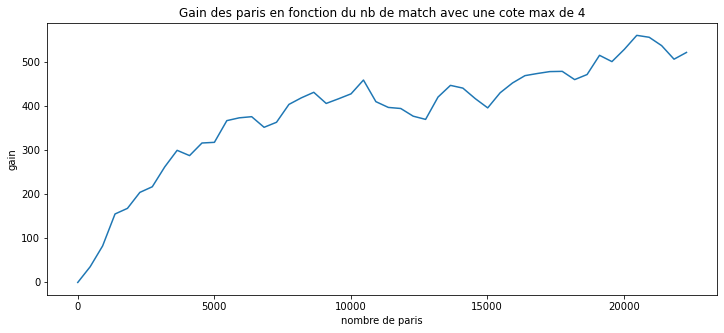

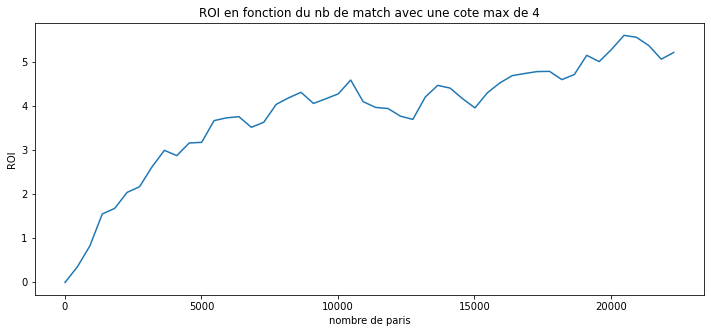

In [51]:
#affichage des gains en fonction du nombre de match pariés
plt.figure(figsize=(12,5))
plt.plot(nombre_de_paris, gain_pari)
plt.xlabel('nombre de paris')
plt.ylabel('gain');
plt.title(f"Gain des paris en fonction du nb de match avec une cote max de {cote_max}")
plt.show()

#affichage des gains en fonction du nombre de match pariés
plt.figure(figsize=(12,5))
plt.plot(nombre_de_paris, ROI)
plt.xlabel('nombre de paris')
plt.ylabel('ROI');
plt.title(f"ROI en fonction du nb de match avec une cote max de {cote_max}")
plt.show()


<p style="color:blue"> Les gains montent rapidement jusqu'à 10000 matchs quelque soit la condition de cote maximale choisie ensuite ils augmentent beaucoup moins vite.
Selon la cote max choisie on remarque que le gain ou ROI max est le meilleur pour des cotes prises en dessous de 3, 3.5.
</p>